In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys, os

def block_print():
    sys.stdout = open(os.devnull, 'w')

def enable_print():
    sys.stdout = sys.__stdout__

In [3]:
from src.PSO.constants import PopulationConfig

population_config = PopulationConfig(seed=42)
population_config.to_dataframe()

,Attribute,Value
0,seed,42.0
1,number_of_room_types,5.0
2,capacity,2808.0
3,corridor_capacity,281.0
4,budget,75105702.3


In [4]:
population_config.rooms_to_dataframe()

,size,frequency_of_use,cost_of_maintenance,cost_of_building,cost_per_day
type,,,,,
0,82,58,6557.94,72098.31,14629.17
1,95,53,177393.94,142965.11,38699.54
2,5,16,24562.27,60991.64,39454.30
3,72,102,187701.83,183849.69,27494.28
4,58,302,72927.00,198917.20,45754.54


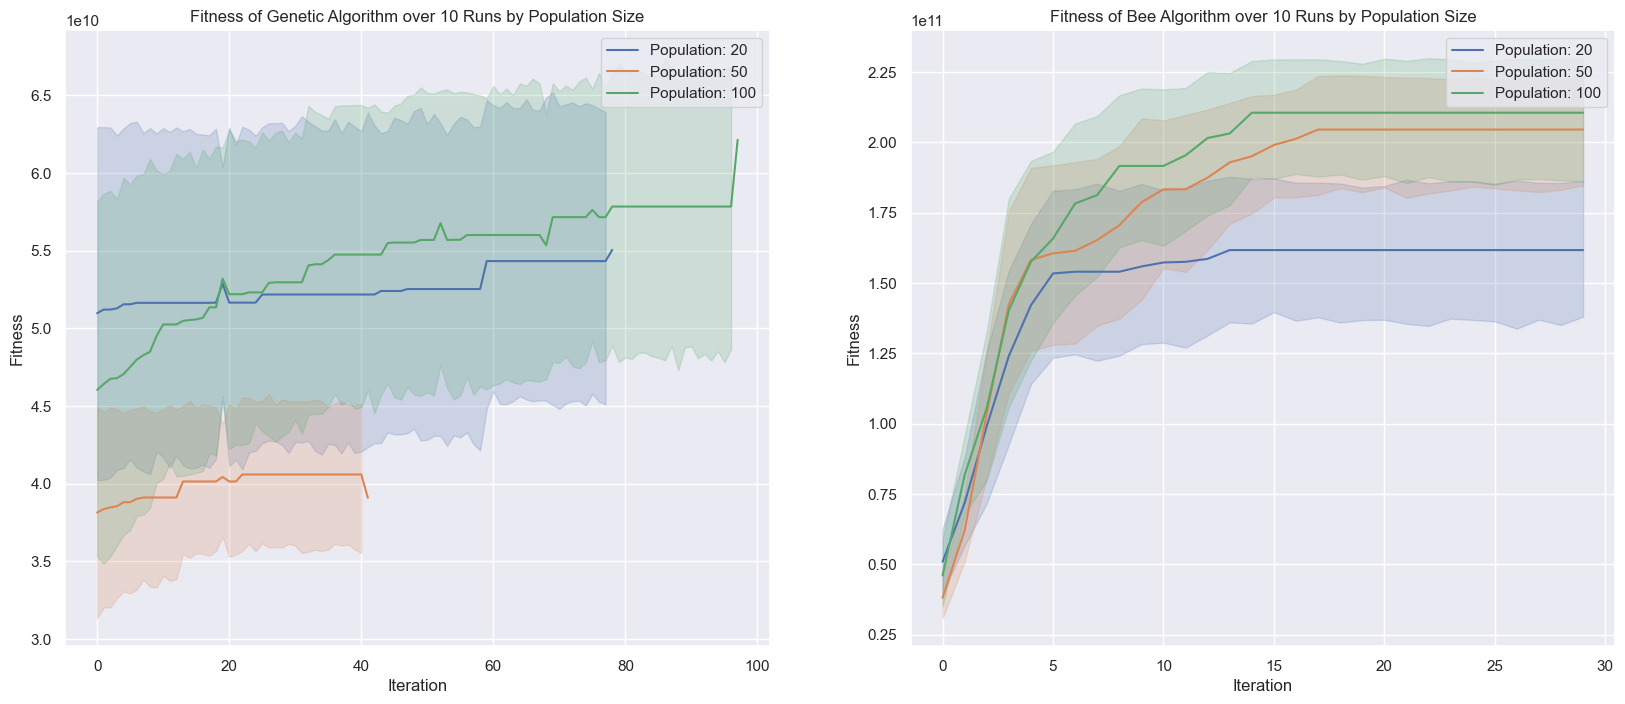

In [10]:
from src.PSO.PSO import bee_algorithm
from src.PSO.constants import BeeOptimizationConfig
from src.genetic import GeneticSearch
from src.populationcreator import PopulationCreator

def fill_in_missing(data: list[pd.DataFrame]):
  """Adjusts all the dataframes to be of equal length. The shorter dataframes are filled with the last value repeatedly."""
  longest, _ = max(data, key=lambda df: len(df)).shape
  for i, df in enumerate(data):
    current_length, _ = df.shape
    
    if current_length == longest:
      continue
    
    last_val = df.iloc[-1, 1]
    missing = longest - current_length
    indexes = list(range(current_length-1, longest))
    values = [last_val]*missing

    df = pd.concat([df, pd.DataFrame(zip(indexes, values), columns=df.columns)], ignore_index=True)
    data[i] = df
      
  return data

def run_convergence_test(population_sizes: list[int], population_config: PopulationConfig) -> dict:
  convergence_data = {}
  
  for size in population_sizes:
    bee_config = BeeOptimizationConfig(num_bees=size, num_iterations=30)
    fitness_history_ga, fitness_history_bso = [None]*10, [None]*10
    
    for i in range(10): 
      population_creator = PopulationCreator(population_config.copy())
      initial_population = population_creator.create(size=size)
      
      algo = GeneticSearch(initial_population.copy())
      algo.run()
      fitness_history_ga_run = algo.best_hist
      fitness_history_ga[i] = pd.DataFrame(fitness_history_ga_run).reset_index()
      
      _, fitness_history_bso_run = bee_algorithm(bee_config.copy(), population_creator, initial_population.copy())

      fitness_history_bso[i] = pd.DataFrame(fitness_history_bso_run).reset_index()
    
    ga_data = pd.concat(fill_in_missing(fitness_history_ga), ignore_index=True)    
    
    bso_data = pd.concat(fitness_history_bso, ignore_index=True)    
    convergence_data[size] = {"GA": ga_data, "BSO": bso_data}
  return convergence_data

population_sizes = [20, 50, 100]
block_print()
convergence_data = run_convergence_test(population_sizes, population_config)
enable_print()


sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))

for size, data in convergence_data.items():
  ga_data = data["GA"]
  sns.lineplot(data=ga_data, x='index', y=0, label=f"Population: {size}", ax=ax1)  # Semi-transparent lines for other runs

  bso_data = data["BSO"]
  sns.lineplot(data=bso_data, x='index', y=0, label=f"Population: {size}", ax=ax2)

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fitness")
ax1.set_title("Fitness of Genetic Algorithm over 10 Runs by Population Size")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fitness")
ax2.set_title("Fitness of Bee Algorithm over 10 Runs by Population Size")

plt.legend()
plt.show()

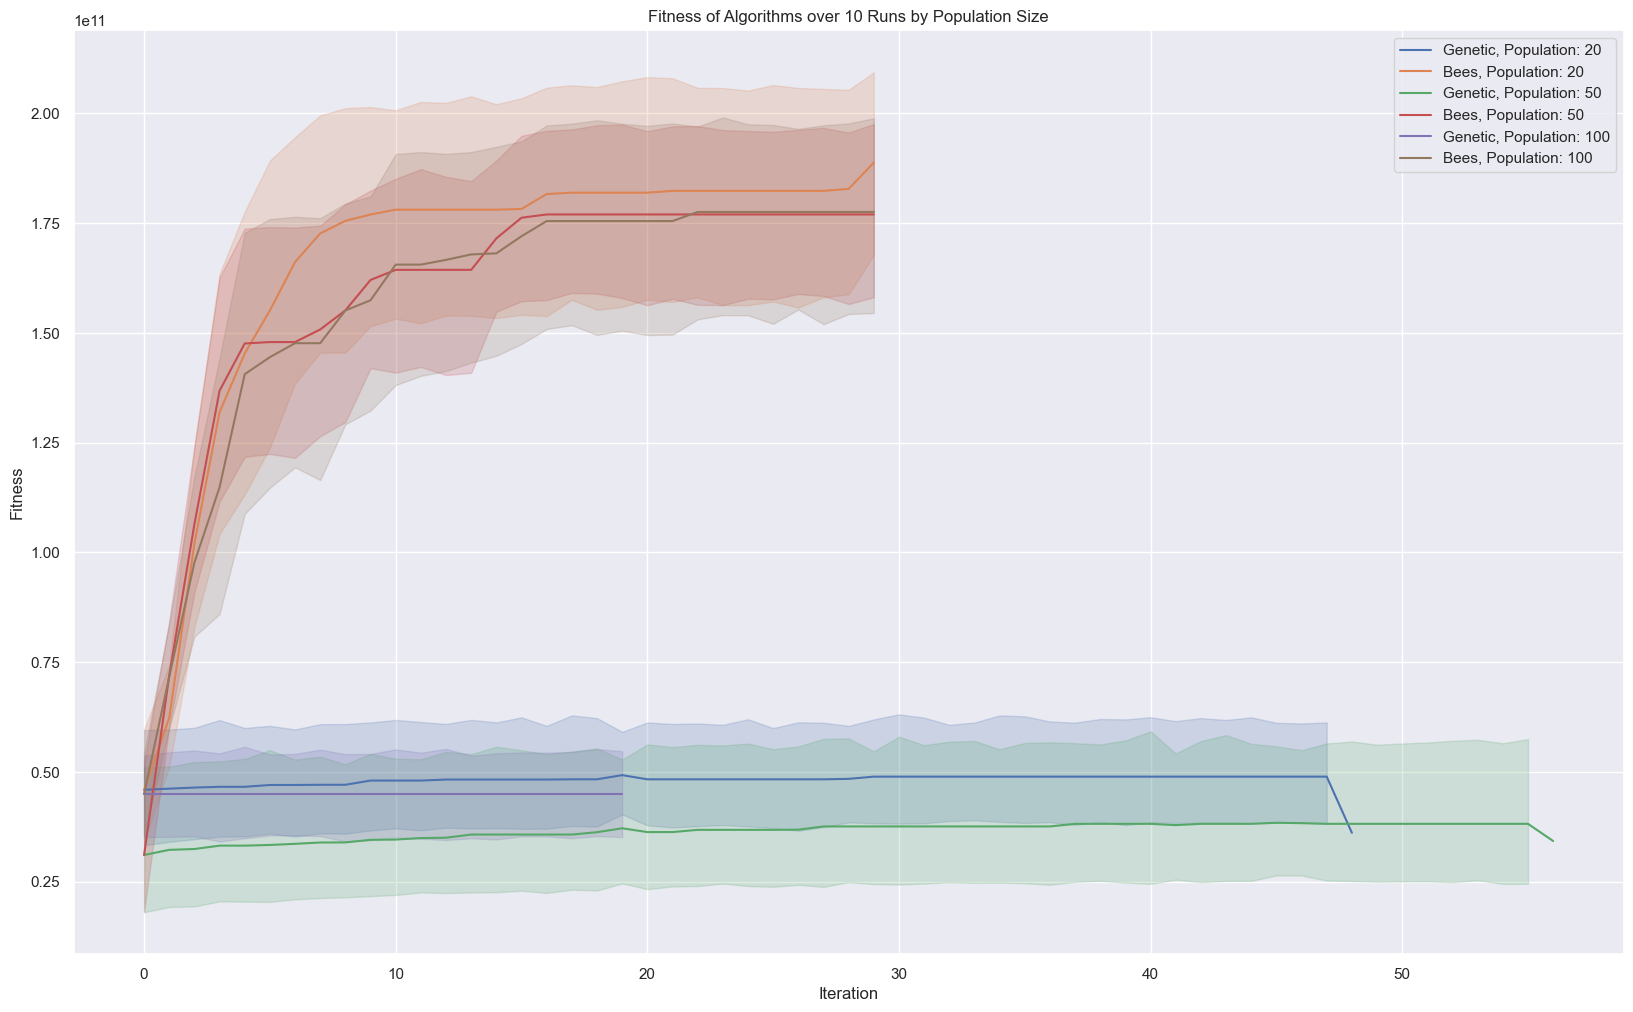

In [6]:
fig = plt.figure(figsize=(20, 12))

for size, data in convergence_data.items():
  ga_data = data["GA"]
  sns.lineplot(data=ga_data, x='index', y=0, label=f"Genetic, Population: {size}")  # Semi-transparent lines for other runs

  bso_data = data["BSO"]
  sns.lineplot(data=bso_data, x='index', y=0, label=f"Bees, Population: {size}")

plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness of Algorithms over 10 Runs by Population Size")
plt.legend()
plt.show()

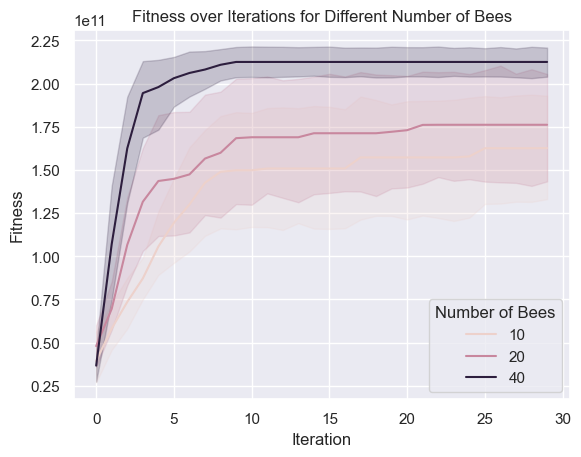

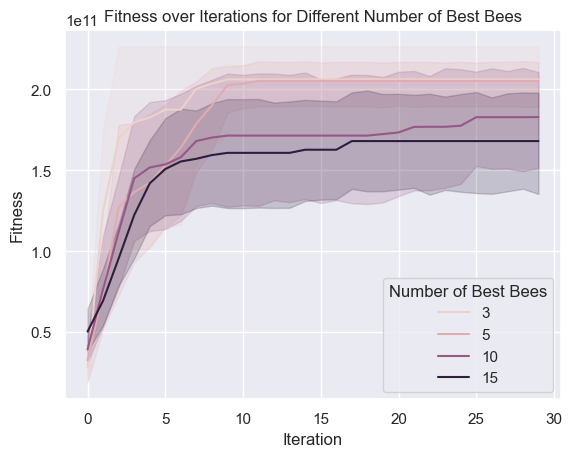

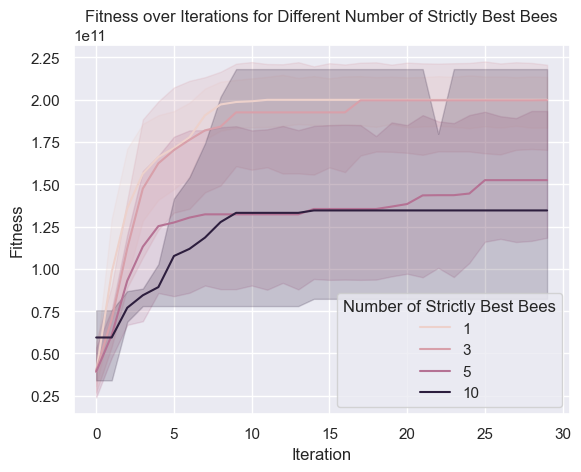

In [7]:
num_bees_array = [10, 20, 40]
num_best_bees_array = [1, 3, 5, 10, 15]
population_creator = PopulationCreator(population_config.copy())
all_fittness_history = []
config_history = []

for num_bees in num_bees_array:
  for i, num_best_bees in enumerate(num_best_bees_array):
    for num_strictly_best_bees in num_best_bees_array[:i]:
      bee_config = BeeOptimizationConfig(num_bees=num_bees, num_strictly_best_bees=num_strictly_best_bees, num_best_bees=num_best_bees)
      if bee_config.bees_random <= 0:
        continue
        
      initial_population = population_creator.create(size=bee_config.num_bees)
      _, fitness_history_bso_run = bee_algorithm(bee_config, population_creator, initial_population)

      for iteration, fitness in enumerate(fitness_history_bso_run):
          all_fittness_history.append({
              'num_bees': num_bees,
              'num_best_bees': num_best_bees,
              'num_strictly_best_bees': num_strictly_best_bees,
              'iteration': iteration,
              'fitness': fitness
          })

      config_history.append(bee_config)


results_df = pd.DataFrame(all_fittness_history)

sns.lineplot(data=results_df, x='iteration', y='fitness', hue='num_bees')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness over Iterations for Different Number of Bees')
plt.legend(title='Number of Bees', loc='lower right')
plt.show()


sns.lineplot(data=results_df, x='iteration', y='fitness', hue='num_best_bees')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness over Iterations for Different Number of Best Bees')
plt.legend(title='Number of Best Bees', loc='lower right')
plt.show()


sns.lineplot(data=results_df, x='iteration', y='fitness', hue='num_strictly_best_bees')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness over Iterations for Different Number of Strictly Best Bees')
plt.legend(title='Number of Strictly Best Bees', loc='lower right')
plt.show()